# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=30"

In [2]:
import requests
import bs4 as soup
from bs4 import BeautifulSoup
from IPython.core.display import HTML, Image
import pandas as pd

In [3]:
# use requests to call hte url
r = requests.get(URL)

In [4]:
# test request
r.request.headers

for k, v in r.request.headers.items():
    print(k + ':', v)
    
HTML(r.content.decode('utf-8'))

('Connection:', 'keep-alive')
('Cookie:', 'BIGipServerjob_iad=!SQMfeSnQTnm4le0RNhs+rOzpOInz89nteEZuP1hGkQZP+1VPCCv99sq87Vns+fTESxi7S94tiJbGVeI=; INDEED_CSRF_TOKEN=ahu9lHcIlUQyKYLlN6tTgk6VPQRaPTTc; ctkgen=1; JSESSIONID=2748AFBAAFAE20BE392D642D43597DDF.jasxA_iad-job19; CTK=1an39567t5un6biu')
('Accept-Encoding:', 'gzip, deflate')
('Accept:', '*/*')
('User-Agent:', 'python-requests/2.9.1')


In [5]:
# test printing out the title 
soup = BeautifulSoup(r.content)
soup.title.text

# test to call company names
for x in soup.findAll('span', class_ = 'company'):
    print x.text



    Gallup

    New York University College of Dentistry



    MLB Advanced Media




    Empiric Solutions




    Rensselaer Polytechnic Institute




    Amazon Corporate LLC




    Google




    Etsy




    JPMorgan Chase




    AIG




    Verizon




    Columbia University


    AbilTo, Inc


    Chegg


    UncommonGoods


/Users/Lydia/anaconda/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [3]:
# read needed info into dataframe
df = pd.DataFrame()
city = ['New+York', 'Chicago', 'San+Francisco', 'Austin','Philadelphia','Houston','Los+Angeles','DC','Boston','Las+Vegas']
for c in city:
    # there are only 100 pages of results available
    for p in range(1,100): 
        url = 'http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l='
        r = requests.get(url + c+'&start=' + str(p*10))
        soup = BeautifulSoup(r.content)
        if p == 10:
            print p
        for x in soup.findAll('div', {'class' : ' row result'}):
            try:
                company = x.find('span', {'itemprop':'name'}).getText().strip() # company name 
                title = x.find('a', {'itemprop':'title'}).getText().strip() # job title
                location = x.find('span', {'itemprop':'addressLocality'}).getText().strip() # location
                description = x.find('span', {'itemprop':'description'}).getText().strip() # abbreviated description
                date = x.find('span', {'class':'date'}).getText().strip()
                salary = x.find('nobr')
                df = df.append({'company': company, 'title': title, 'post_date': date, 'location': location, 'description': description, 'salary':salary}, ignore_index=True)
            except:
                pass

/Users/Lydia/anaconda/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


10
10
10
10
10
10
10
10
10
10


In [10]:
# check rows we received with salary info 
sum(df.salary.value_counts())

658

In [11]:
df

,company,description,location,post_date,salary,title
0,WebMD,Provide data analysis and facilitate comprehen...,"New York, NY",17 days ago,None,"Team Lead, Data Analysis"
1,Columbia University,Experience in the analysis and interpretation ...,"Palisades, NY",1 day ago,None,Postdoctoral Research Scientist
2,Celmatix,We seek a Senior Data Scientist with deep expe...,"New York, NY 10005 (Financial District area)",9 days ago,None,Senior Data Scientist
3,NBCUniversal,"Help business analysts, application engineers,...","New York, NY",9 days ago,None,"Data Engineer, Analytics Technology"
4,Google,Experience interpreting technical data and cre...,"New York, NY 10011 (Chelsea area)",1 hour ago,None,"Machine Learning Deployment Engineer, Cloud Pr..."
5,NYU Langone Medical Center,The individual is responsibile for data collec...,"New York, NY 10016 (Gramercy area)",2 days ago,None,Data Analyst
6,"Two Sigma Investments, LLC.","Two Sigma combines massive amounts of data, wo...","New York, NY",23 days ago,None,Quantitative Researcher in Machine Learning
7,"Stemline Therapeutics, Inc.","Develop, organize, and maintain system of data...","New York, NY 10022 (Midtown area)",6 days ago,None,"Research Associate, R&D"
8,About.com,"As a Senior Data Scientist, you will be respon...","New York, NY 10018 (Clinton area)",1 day ago,None,Senior Data Scientist
9,DBRS,"Lead Data Scientist, US RMBS. The Lead Data Sc...","New York, NY 10005 (Financial District area)",22 days ago,None,"Lead Data Scientist, US RMBS"


In [12]:
df.info()

In [124]:
# new dataframe with any cities, fulltime job only
ft = pd.DataFrame()

for p in range(1,100): 
    url = 'http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&jt=fulltime&start='
    r = requests.get(url + str(p*10))
    soup = BeautifulSoup(r.content)
    for x in soup.findAll('div', {'class' : ' row result'}):
        try:
            company = x.find('span', {'itemprop':'name'}).getText().strip() # company name 
            title = x.find('a', {'itemprop':'title'}).getText().strip() # job title
            location = x.find('span', {'itemprop':'addressLocality'}).getText().strip() # location
            description = x.find('span', {'itemprop':'description'}).getText().strip() # abbreviated description
            date = x.find('span', {'class':'date'}).getText().strip()
            salary = x.find('nobr')
            ft = ft.append({'company': company, 'title': title, 'post_date': date, 'location': location, 'description': description, 'salary':salary}, ignore_index=True)
        except:
            pass

In [14]:
df.info()

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- Make sure these functions are robust and can handle cases where the data/field may not be available.
- Test the functions on the results above

In [25]:
## alternatively using function to extract items


Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

In [26]:
YOUR_CITY = ''

In [27]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 100

results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', YOUR_CITY]):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        # Append to the full set of results
        pass

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [28]:
## YOUR CODE HERE

Lastly, we need to clean up salary data. 
1. Some of the salaries are not yearly but hourly, these will be useful to us for now
2. The salaries are given as text and usually with ranges.

#### Filter out the salaries that are not yearly (filter those that refer to hour)

In [29]:
## YOUR CODE HERE


#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary

In [30]:
## YOUR CODE HERE

# Cleaning data!

In [126]:
import numpy as np

# creating temp columns to split up the addresses in to city and states
ft['temp'] = [x.split(',') for x in ft.location]

# assign cities into a new column
ft['city'] = [x[0] for x in ft.temp] 
ft['temp1'] = [x[1:] for x in ft.temp] 

# assign states into a new column
states = []
for x in ft.temp1:
    try: 
        states.append(str(x)[4] + str(x)[5]) 
    except: 
        states.append(np.nan)
ft['state'] = states

In [127]:
# check out suspecious looking cities
ft.city.unique()
ft.city.value_counts()
temp = ft.ix[(ft['city'] == 'United States') | (ft['city'] =='Job') | (ft['city'] == 'Remote') | (ft['city'] =='New Jersey')]

In [128]:
temp

,company,description,location,post_date,salary,title,temp,city,temp1,state
45,Quintiles Transnational, Conducts in-stream data trend analysis in su...,United States,23 days ago,None,Medical Data Review Mgr,[United States],United States,[],NaN
103,J & J Consumer Inc.,The Senior Scientist will:. The Senior Scienti...,New Jersey,30+ days ago,None,"Senior Scientist, Data Sciences",[New Jersey],New Jersey,[],NaN
117,Allergan,Clinical Research Scientist. Site/vendor manag...,New Jersey,5 days ago,None,Clinical Research Scientist,[New Jersey],New Jersey,[],NaN
127,Quintiles Transnational,Whether you are beginning or continuing your c...,United States,1 day ago,None,Statistical Programmer 1 - Officebased Overlan...,[United States],United States,[],NaN
203,Environmental Defense Fund,Synthesize and disseminate that information fo...,United States,3 hours ago,None,"Research Analyst, Oil & Gas",[United States],United States,[],NaN
233,VSCO,Experience with large scale data pipelines and...,United States,1 day ago,None,Machine Learning Engineer,[United States],United States,[],NaN
289,RAND Corporation,"Clean and analyze survey data using SAS, Stata...",United States,30+ days ago,None,Statistical Programmer/Analyst,[United States],United States,[],NaN
313,Riverland Community College,Demonstrated commitment to data integrity. Abi...,United States,4 days ago,"<nobr>$3,055 a month</nobr>",Research Analyst Intermediate,[United States],United States,[],NaN
566,Agilent,3+ years of experience working in an analytica...,United States,9 days ago,None,Services Reporting and Analytics Manager,[United States],United States,[],NaN
582,Avalance,You will architect front-end components that m...,Remote,9 days ago,None,Data Visualization Engineer,[Remote],Remote,[],NaN


In [129]:
# get rid off wrong city
ft.city.replace('Remote',np.nan, inplace =True)    
ft.city.replace('Job',np.nan, inplace =True) 
ft.city.replace('United States',np.nan, inplace =True) 

In [130]:
# Reassign city 'New Jersey' to state
ft.state[ft['city'] == 'New Jersey'] = 'NJ'
ft.city[ft['city'] == 'New Jersey'] = np.nan
# check if it's been reassigned
ft[ft['company'] == 'J & J Consumer Inc.']

,company,description,location,post_date,salary,title,temp,city,temp1,state
103,J & J Consumer Inc.,The Senior Scientist will:. The Senior Scienti...,New Jersey,30+ days ago,None,"Senior Scientist, Data Sciences",[New Jersey],NaN,[],NJ


In [24]:
# check state column 
ft.state.value_counts()

NameError: name 'ft' is not defined

In [132]:
# drop the temp columns 
ft = ft.drop(['temp','temp1'], axis = 1)

In [133]:
# check salary info
ft.salary.value_counts()

<nobr>$150,000 a year</nobr>               5
<nobr>$120,000 a year</nobr>               3
<nobr>$160,000 a year</nobr>               3
<nobr>$100,000 a year</nobr>               2
<nobr>$115,000 - $150,000 a year</nobr>    2
<nobr>$90,000 a year</nobr>                2
<nobr>$125,000 a year</nobr>               2
<nobr>$77,490 - $119,794 a year</nobr>     2
<nobr>$110,000 - $180,000 a year</nobr>    2
<nobr>$125,000 - $145,000 a year</nobr>    2
<nobr>$105,000 a year</nobr>               2
<nobr>$110,000 a year</nobr>               2
<nobr>$85,000 a year</nobr>                2
<nobr>$75,000 a year</nobr>                2
<nobr>$59,966 a year</nobr>                1
<nobr>$3,580 - $5,047 a month</nobr>       1
<nobr>$130,000 - $175,000 a year</nobr>    1
<nobr>$55,000 - $65,000 a year</nobr>      1
<nobr>$32,900 a year</nobr>                1
<nobr>$150,000 - $200,000 a year</nobr>    1
<nobr>$100,000 - $130,000 a year</nobr>    1
<nobr>$76,341 - $99,243 a year</nobr>      1
<nobr>$60,

In [134]:
# change salary to string 
def to_string(x):
    try:
        y = str(x)
        return y
    except:
        pass  

ft.salary = ft.salary.apply(to_string)

# check data type 
type(ft.salary[16])

str

In [137]:
# create new columns for different types of salary
ft.loc[ft.salary.str.contains('year'), 'yearly_salary'] = ft['salary']
ft.loc[ft.salary.str.contains('month'), 'monthly_salary'] = ft['salary']

In [138]:
ft.yearly_salary

0                                        NaN
1                                        NaN
2                                        NaN
3                                        NaN
4                                        NaN
5                                        NaN
6               <nobr>$125,000 a year</nobr>
7                                        NaN
8                                        NaN
9                                        NaN
10                                       NaN
11                                       NaN
12                                       NaN
13                                       NaN
14               <nobr>$71,282 a year</nobr>
15                                       NaN
16              <nobr>$110,000 a year</nobr>
17                                       NaN
18                                       NaN
19                                       NaN
20                                       NaN
21                                       NaN
22        

In [136]:
# seperating yearly salary column 
for x in ft.yearly_salary: 
    try:
        print x
        print x.split()
        print x.split()[0]
        print x.split()[2]
        print ''
    except:
        pass

nan
nan
nan
nan
nan
nan
<nobr>$125,000 a year</nobr>
['<nobr>$125,000', 'a', 'year</nobr>']
<nobr>$125,000
year</nobr>

nan
nan
nan
nan
nan
nan
nan
<nobr>$71,282 a year</nobr>
['<nobr>$71,282', 'a', 'year</nobr>']
<nobr>$71,282
year</nobr>

nan
<nobr>$110,000 a year</nobr>
['<nobr>$110,000', 'a', 'year</nobr>']
<nobr>$110,000
year</nobr>

nan
nan
nan
nan
nan
<nobr>$120,000 a year</nobr>
['<nobr>$120,000', 'a', 'year</nobr>']
<nobr>$120,000
year</nobr>

nan
<nobr>$59,966 a year</nobr>
['<nobr>$59,966', 'a', 'year</nobr>']
<nobr>$59,966
year</nobr>

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
<nobr>$150,000 a year</nobr>
['<nobr>$150,000', 'a', 'year</nobr>']
<nobr>$150,000
year</nobr>

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
<nobr>$108,777 a year</nobr>
['<nobr>$108,777', 'a', 'year</nobr>']
<nobr>$108,777
year</nobr>

nan
<nobr>$170,000 - $200,000 a year</nobr>
['<nobr>$170,000', '-', '$200,000', 'a', 'year</nobr>']
<nobr>$170,000
$200,00

In [139]:
# create new column for high and low range
range_l = []
range_h = []
for x in ft['yearly_salary']: 
    try:
        range_l.append(x.split()[0])
        range_h.append(x.split()[2])
    except:
        range_l.append(np.nan)
        range_h.append(np.nan)
ft['range_low'] = range_l
ft['range_high'] = range_h
ft

,company,description,location,post_date,salary,title,city,state,yearly_salary,monthly_salary,range_low,range_high
0,Quantitative Radiology Solutions,Test existing algorithms on radiation therapy ...,"Philadelphia, PA",12 days ago,None,Image Analysis Scientist,Philadelphia,PA,NaN,NaN,NaN,NaN
1,University of California Berkeley,Experienced in working with a small to med siz...,"Berkeley, CA",30+ days ago,None,"Associate Director of Data Analysis, Haas Scho...",Berkeley,CA,NaN,NaN,NaN,NaN
2,Google,Please note that this position is the same as ...,"Mountain View, CA",2 days ago,None,"Statistician/Quantitative Analyst, Engineering",Mountain View,CA,NaN,NaN,NaN,NaN
3,Markit,Daily activities include data processing monit...,"New York, NY",5 hours ago,None,Quantitative Analyst,New York,NY,NaN,NaN,NaN,NaN
4,Spreemo,"As a Senior Data Scientist at Spreemo, you wil...","New York, NY 10012 (Little Italy area)",2 days ago,None,Senior Data Scientist,New York,NY,NaN,NaN,NaN,NaN
5,Google,Data Scientists are changing the world one tec...,"San Bruno, CA",2 days ago,None,"Product Analyst, Data Sciences",San Bruno,CA,NaN,NaN,NaN,NaN
6,ResourceHunt Group,Senior Research Scientist*. Write technical re...,"Yaphank, NY",23 hours ago,"<nobr>$125,000 a year</nobr>",Senior Research Scientist,Yaphank,NY,"<nobr>$125,000 a year</nobr>",NaN,"<nobr>$125,000",year</nobr>
7,NYU Langone Medical Center,Uses tools to facilitate data collection (e.g....,"New York, NY 10016 (Gramercy area)",1 hour ago,None,Research Data Associate,New York,NY,NaN,NaN,NaN,NaN
8,Otis,You are the primary data domain expert and wil...,"West Palm Beach, FL",2 days ago,None,Data Warehouse / BI Engineer - Data Transfer,West Palm Beach,FL,NaN,NaN,NaN,NaN
9,Paperless Post,Decision science and data analytics. You’ll le...,"New York, NY",6 days ago,None,Director of Data Science and Analytics,New York,NY,NaN,NaN,NaN,NaN


In [140]:
# clean up range low 
def clean_h(x):
    try: 
        y = x.replace('$','')
        z = y.replace(',','')
        return z
    except: 
        pass
ft['range_high']= ft['range_high'].apply(clean_h)

ft['range_high'].replace('year</nobr>',np.nan, inplace =True)    

In [142]:
ft['range_high'].value_counts()

180000    3
200000    3
150000    3
160000    2
90000     2
145000    2
130000    2
119794    2
114802    1
175000    1
110000    1
143229    1
185100    1
58056     1
50000     1
75012     1
165000    1
57657     1
98000     1
120000    1
73935     1
51120     1
80000     1
300000    1
85000     1
198204    1
73644     1
60000     1
60531     1
99243     1
84141     1
60715     1
141555    1
155000    1
92700     1
65000     1
Name: range_high, dtype: int64

In [145]:
# clean up range low 
def clean_l(x):
    try: 
        y = x.replace('<nobr>$','')
        z = y.replace(',','')
        return z
    except: 
        pass
ft['range_low'] = ft['range_low'].apply(clean_l)

ft['range_low'].value_counts()

150000    7
100000    6
110000    5
120000    5
125000    4
90000     4
160000    3
115000    2
80000     2
130000    2
105000    2
200000    2
50000     2
70000     2
60000     2
55000     2
85000     2
77490     2
75000     2
42168     1
46562     1
40000     1
123175    1
185000    1
89523     1
45000     1
56136     1
32900     1
165000    1
45219     1
50648     1
43692     1
74260     1
46305     1
58700     1
59966     1
138300    1
35000     1
44969     1
170000    1
53900     1
103000    1
76000     1
65993     1
120525    1
190000    1
76341     1
46857     1
39960     1
71282     1
108777    1
180000    1
53875     1
92145     1
Name: range_low, dtype: int64

In [16]:
for x in ft.range_high():
    

IndentationError: expected an indented block (<ipython-input-16-3519454f5b7b>, line 2)

## Clean DF

In [3]:
df = pd.read_csv('final_df.csv')

In [4]:
df

,Unnamed: 0,company,description,location,post_date,salary,title
0,0,WebMD,Provide data analysis and facilitate comprehen...,"New York, NY",17 days ago,NaN,"Team Lead, Data Analysis"
1,1,Columbia University,Experience in the analysis and interpretation ...,"Palisades, NY",1 day ago,NaN,Postdoctoral Research Scientist
2,2,Celmatix,We seek a Senior Data Scientist with deep expe...,"New York, NY 10005 (Financial District area)",9 days ago,NaN,Senior Data Scientist
3,3,NBCUniversal,"Help business analysts, application engineers,...","New York, NY",9 days ago,NaN,"Data Engineer, Analytics Technology"
4,4,Google,Experience interpreting technical data and cre...,"New York, NY 10011 (Chelsea area)",1 hour ago,NaN,"Machine Learning Deployment Engineer, Cloud Pr..."
5,5,NYU Langone Medical Center,The individual is responsibile for data collec...,"New York, NY 10016 (Gramercy area)",2 days ago,NaN,Data Analyst
6,6,"Two Sigma Investments, LLC.","Two Sigma combines massive amounts of data, wo...","New York, NY",23 days ago,NaN,Quantitative Researcher in Machine Learning
7,7,"Stemline Therapeutics, Inc.","Develop, organize, and maintain system of data...","New York, NY 10022 (Midtown area)",6 days ago,NaN,"Research Associate, R&D"
8,8,About.com,"As a Senior Data Scientist, you will be respon...","New York, NY 10018 (Clinton area)",1 day ago,NaN,Senior Data Scientist
9,9,DBRS,"Lead Data Scientist, US RMBS. The Lead Data Sc...","New York, NY 10005 (Financial District area)",22 days ago,NaN,"Lead Data Scientist, US RMBS"


In [11]:
import numpy as np

# creating temp columns to split up the addresses in to city and states
df['temp'] = [x.split(',') for x in df.location]

# assign cities into a new column
df['city'] = [x[0] for x in df.temp] 
df['temp1'] = [x[1:] for x in df.temp] 

# assign states into a new column
states = []
for x in df.temp1:
    try: 
        states.append(str(x)[3] + str(x)[4]) 
    except: 
        states.append(np.nan)
df['state'] = states

In [12]:
df

,Unnamed: 0,company,description,location,post_date,salary,title,temp,city,temp1,state
0,0,WebMD,Provide data analysis and facilitate comprehen...,"New York, NY",17 days ago,NaN,"Team Lead, Data Analysis","[New York, NY]",New York,[ NY],NY
1,1,Columbia University,Experience in the analysis and interpretation ...,"Palisades, NY",1 day ago,NaN,Postdoctoral Research Scientist,"[Palisades, NY]",Palisades,[ NY],NY
2,2,Celmatix,We seek a Senior Data Scientist with deep expe...,"New York, NY 10005 (Financial District area)",9 days ago,NaN,Senior Data Scientist,"[New York, NY 10005 (Financial District area)]",New York,[ NY 10005 (Financial District area)],NY
3,3,NBCUniversal,"Help business analysts, application engineers,...","New York, NY",9 days ago,NaN,"Data Engineer, Analytics Technology","[New York, NY]",New York,[ NY],NY
4,4,Google,Experience interpreting technical data and cre...,"New York, NY 10011 (Chelsea area)",1 hour ago,NaN,"Machine Learning Deployment Engineer, Cloud Pr...","[New York, NY 10011 (Chelsea area)]",New York,[ NY 10011 (Chelsea area)],NY
5,5,NYU Langone Medical Center,The individual is responsibile for data collec...,"New York, NY 10016 (Gramercy area)",2 days ago,NaN,Data Analyst,"[New York, NY 10016 (Gramercy area)]",New York,[ NY 10016 (Gramercy area)],NY
6,6,"Two Sigma Investments, LLC.","Two Sigma combines massive amounts of data, wo...","New York, NY",23 days ago,NaN,Quantitative Researcher in Machine Learning,"[New York, NY]",New York,[ NY],NY
7,7,"Stemline Therapeutics, Inc.","Develop, organize, and maintain system of data...","New York, NY 10022 (Midtown area)",6 days ago,NaN,"Research Associate, R&D","[New York, NY 10022 (Midtown area)]",New York,[ NY 10022 (Midtown area)],NY
8,8,About.com,"As a Senior Data Scientist, you will be respon...","New York, NY 10018 (Clinton area)",1 day ago,NaN,Senior Data Scientist,"[New York, NY 10018 (Clinton area)]",New York,[ NY 10018 (Clinton area)],NY
9,9,DBRS,"Lead Data Scientist, US RMBS. The Lead Data Sc...","New York, NY 10005 (Financial District area)",22 days ago,NaN,"Lead Data Scientist, US RMBS","[New York, NY 10005 (Financial District area)]",New York,[ NY 10005 (Financial District area)],NY


In [13]:
# check out suspecious looking cities
df.city.unique()
df.city.value_counts()
temp = df.ix[(df['city'] == 'United States') | (df['city'] =='Job') | (df['city'] == 'Remote') | (df['city'] =='New Jersey')]
temp

,Unnamed: 0,company,description,location,post_date,salary,title,temp,city,temp1,state


In [14]:
# check state column 
df.state.value_counts()

CA    1393
TX    1040
MA     890
NY     886
IL     752
NV     693
PA     611
VA     346
MD     316
DC     229
DE      80
NJ      11
IN       2
Name: state, dtype: int64

In [15]:
# change salary to string 
def to_string(x):
    try:
        y = str(x)
        return y
    except:
        pass  

df.salary = df.salary.apply(to_string)

# check data type 
type(df.salary[16])

str

In [16]:
# create new columns for different types of salary
df.loc[df.salary.str.contains('year'), 'yearly_salary'] = df['salary']
df.loc[df.salary.str.contains('month'), 'monthly_salary'] = df['salary']

In [17]:
# seperating yearly salary column 
for x in df.yearly_salary: 
    try:
        print x
        print x.split()
        print x.split()[0]
        print x.split()[2]
        print ''
    except:
        pass

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
<nobr>$150,000 a year</nobr>
['<nobr>$150,000', 'a', 'year</nobr>']
<nobr>$150,000
year</nobr>

nan
nan
nan
nan
nan
nan
<nobr>$170,000 - $200,000 a year</nobr>
['<nobr>$170,000', '-', '$200,000', 'a', 'year</nobr>']
<nobr>$170,000
$200,000

nan
nan
nan
nan
nan
<nobr>$130,000 a year</nobr>
['<nobr>$130,000', 'a', 'year</nobr>']
<nobr>$130,000
year</nobr>

nan
nan
nan
nan
nan
nan
nan
nan
<nobr>$100,000 - $200,000 a year</nobr>
['<nobr>$100,000', '-', '$200,000', 'a', 'year</nobr>']
<nobr>$100,000
$200,000

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
<nobr>$105,000 a year</nobr>
['<nobr>$105,000', 'a', 'year</nobr>']
<nobr>$105,000
year</nobr>

nan
nan
nan
nan
nan
nan
<nobr>$150,000 a year</nobr>
['<nobr>$150,000', 'a', 'year</nobr>']
<nobr>$150,000
year</nobr>

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
<nobr>$135,000

In [18]:
# create new column for high and low range
range_l = []
range_h = []
for x in df['yearly_salary']: 
    try:
        range_l.append(x.split()[0])
        range_h.append(x.split()[2])
    except:
        range_l.append(np.nan)
        range_h.append(np.nan)
df['range_low'] = range_l
df['range_high'] = range_h
df

,Unnamed: 0,company,description,location,post_date,salary,title,temp,city,temp1,state,yearly_salary,monthly_salary,range_low,range_high
0,0,WebMD,Provide data analysis and facilitate comprehen...,"New York, NY",17 days ago,nan,"Team Lead, Data Analysis","[New York, NY]",New York,[ NY],NY,NaN,NaN,NaN,NaN
1,1,Columbia University,Experience in the analysis and interpretation ...,"Palisades, NY",1 day ago,nan,Postdoctoral Research Scientist,"[Palisades, NY]",Palisades,[ NY],NY,NaN,NaN,NaN,NaN
2,2,Celmatix,We seek a Senior Data Scientist with deep expe...,"New York, NY 10005 (Financial District area)",9 days ago,nan,Senior Data Scientist,"[New York, NY 10005 (Financial District area)]",New York,[ NY 10005 (Financial District area)],NY,NaN,NaN,NaN,NaN
3,3,NBCUniversal,"Help business analysts, application engineers,...","New York, NY",9 days ago,nan,"Data Engineer, Analytics Technology","[New York, NY]",New York,[ NY],NY,NaN,NaN,NaN,NaN
4,4,Google,Experience interpreting technical data and cre...,"New York, NY 10011 (Chelsea area)",1 hour ago,nan,"Machine Learning Deployment Engineer, Cloud Pr...","[New York, NY 10011 (Chelsea area)]",New York,[ NY 10011 (Chelsea area)],NY,NaN,NaN,NaN,NaN
5,5,NYU Langone Medical Center,The individual is responsibile for data collec...,"New York, NY 10016 (Gramercy area)",2 days ago,nan,Data Analyst,"[New York, NY 10016 (Gramercy area)]",New York,[ NY 10016 (Gramercy area)],NY,NaN,NaN,NaN,NaN
6,6,"Two Sigma Investments, LLC.","Two Sigma combines massive amounts of data, wo...","New York, NY",23 days ago,nan,Quantitative Researcher in Machine Learning,"[New York, NY]",New York,[ NY],NY,NaN,NaN,NaN,NaN
7,7,"Stemline Therapeutics, Inc.","Develop, organize, and maintain system of data...","New York, NY 10022 (Midtown area)",6 days ago,nan,"Research Associate, R&D","[New York, NY 10022 (Midtown area)]",New York,[ NY 10022 (Midtown area)],NY,NaN,NaN,NaN,NaN
8,8,About.com,"As a Senior Data Scientist, you will be respon...","New York, NY 10018 (Clinton area)",1 day ago,nan,Senior Data Scientist,"[New York, NY 10018 (Clinton area)]",New York,[ NY 10018 (Clinton area)],NY,NaN,NaN,NaN,NaN
9,9,DBRS,"Lead Data Scientist, US RMBS. The Lead Data Sc...","New York, NY 10005 (Financial District area)",22 days ago,nan,"Lead Data Scientist, US RMBS","[New York, NY 10005 (Financial District area)]",New York,[ NY 10005 (Financial District area)],NY,NaN,NaN,NaN,NaN


In [19]:
# clean up range low 
def clean_h(x):
    try: 
        y = x.replace('$','')
        z = y.replace(',','')
        return z
    except: 
        pass
df['range_high']= df['range_high'].apply(clean_h)

df['range_high'].replace('year</nobr>',np.nan, inplace =True)    
df['range_high'].value_counts()

95000     86
200000    17
150000    14
119794    14
160000    14
130000    11
141555    10
250000     7
180000     7
160300     6
85644      6
120000     6
110000     6
165000     4
140000     4
84044      4
145000     4
90000      4
75000      4
125000     3
185100     3
169686     3
135000     3
155000     3
175000     2
70142      2
121525     2
60000      2
170000     2
84611      2
          ..
61669      1
91073      1
198204     1
62000      1
45000      1
51120      1
42000      1
100322     1
150202     1
77000      1
22496      1
240000     1
61441      1
40000      1
97000      1
64920      1
275000     1
145991     1
195000     1
83721      1
120187     1
88649      1
56000      1
80000      1
113650     1
215000     1
94834      1
36000      1
146570     1
97794      1
Name: range_high, dtype: int64

In [20]:
# clean up range low 
def clean_l(x):
    try: 
        y = x.replace('<nobr>$','')
        z = y.replace(',','')
        return z
    except: 
        pass
df['range_low'] = df['range_low'].apply(clean_l)

df['range_low'].value_counts()

60000     94
150000    24
100000    23
120000    15
130000    13
110000    13
140000    11
80000     11
77490      9
85000      9
92145      9
90000      8
108887     8
70000      7
200000     6
68239      6
50000      6
65000      6
115000     6
180000     5
145000     4
165000     4
128082     4
170000     4
95000      3
119776     3
160000     3
125000     3
81878      2
135000     2
          ..
78687      1
74566      1
20093      1
75900      1
45488      1
49012      1
55666      1
65899      1
73867      1
75243      1
28000      1
82000      1
109245     1
61848      1
56000      1
55603      1
160300     1
61000      1
48968      1
87955      1
98393      1
64862      1
49506      1
62338      1
120525     1
71152      1
185000     1
61031      1
137494     1
47262      1
Name: range_low, dtype: int64

In [34]:
temp['high'] = df["range_high"]
temp['low'] = df["range_low"]
for x in 

/Users/Lydia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Lydia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5      NaN
6      NaN
7      NaN
8      NaN
9      NaN
10     NaN
11     NaN
12     NaN
13     NaN
14     NaN
15     NaN
16     NaN
17     NaN
18     NaN
19     NaN
20     NaN
21     NaN
22     NaN
23     NaN
24     NaN
25     NaN
26     NaN
27     NaN
28     NaN
29     NaN
        ..
7222   NaN
7223   NaN
7224   NaN
7225   NaN
7226   NaN
7227   NaN
7228   NaN
7229   NaN
7230   NaN
7231   NaN
7232   NaN
7233   NaN
7234   NaN
7235   NaN
7236   NaN
7237   NaN
7238   NaN
7239   NaN
7240   NaN
7241   NaN
7242   NaN
7243   NaN
7244   NaN
7245   NaN
7246   NaN
7247   NaN
7248   NaN
7249   NaN
7250   NaN
7251   NaN
dtype: float64

In [35]:
temp

,range_high,range_low,high,low
0,None,None,None,None
1,None,None,None,None
2,None,None,None,None
3,None,None,None,None
4,None,None,None,None
5,None,None,None,None
6,None,None,None,None
7,None,None,None,None
8,None,None,None,None
9,None,None,None,None


### Save your results as a CSV

In [5]:
## YOUR CODE HERE
import sys
reload(sys)
sys.setdefaultencoding('utf-8')
# write to file 
df.to_csv('final_df.csv')

## Predicting salaries using Logistic Regression

#### Load in the the data of scraped salaries

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [72]:
ndf = pd.read_csv('../../../project_data/indeed-scraped-job-postings.csv')
ndf.company.value_counts()

University of Texas at Austin                           2279
Workbridge Associates                                   1146
Emoters Robotics                                         390
Clinical Management Consultants                          389
Analytic Recruiting                                      341
University of Washington Medical Center                   52
DEPT OF HEALTH/MENTAL HYGIENE                             17
All-In Analytics                                          13
University of Washington                                  13
Jobspring Partners                                         7
Selby Jennings                                             7
Smith Hanley Associates                                    6
University of California Berkeley                          5
Averity                                                    5
NJF Search                                                 4
ADMIN FOR CHILDREN'S SVCS                                  4
DEPARTMENT OF FINANCE   

In [19]:
def clean_c(x):
    y = x.replace('+',' ')
    return y
ndf['city'] = ndf['city'].apply(clean_c)

In [73]:
ndf.loc[ndf.salary.str.contains('month'), 'salary_type'] = 'month'
ndf.loc[ndf.salary.str.contains('year'), 'salary_type'] = 'year'

In [21]:
ndf['salary'] = ndf['parsed_salary']

In [22]:
ndf = ndf.drop(['parsed_salary'], axis=1)

In [75]:
# Check duplicated data
ndf.duplicated().value_counts()
# drop duplicated data 
ndf = ndf.drop_duplicates()

In [77]:
ndf.salary_type.value_counts()

year     175
month     48
Name: salary_type, dtype: int64

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

In [24]:
## YOUR CODE HERE
ndf['salary_v'] = ndf['salary'].map(lambda x: 'high' if x > ndf['salary'].mean() else 'low')

#### Thought experiment: What is the baseline accuracy for this model?

The average salary plays a big role in this model because if the average salary of this sample cannot accurately represent the average of this population, this model cannot accurately predict for the other sets of data. Baseline is going to be the variabl that the model is comparing everything else to, in this case, one of those cities that will be dropped after the dummy variables are created. It also avoids dummy variable trap.

#### Create a Logistic Regression model to predict High/Low salary using statsmodel. Start by ONLY using the location as a feature. Display the coefficients and write a short summary of what they mean.

In [25]:
# create target variable
ndf['salary_b'] = ndf['salary_v'].map(lambda x: 1 if x == 'high' else 0)

In [26]:
# create dummy variables
dummies = pd.get_dummies(ndf['city'])
ndf

,city,company,salary,summary,title,salary_type,salary_v,salary_b
0,San Francisco,MarkMonitor,180000.0,"Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,year,high,1
1,San Francisco,Workbridge Associates,155000.0,3+ years of industry experience in a data scie...,Senior Data Scientist,year,high,1
2,San Francisco,Mines.io,100000.0,We are looking for a data scientist/developer ...,Full-Stack Data Scientist,year,high,1
3,San Francisco,Workbridge Associates,165000.0,In this position you will share programming an...,Data Scientist,year,high,1
4,San Francisco,Smith Hanley Associates,140000.0,"This person will recruit, build and lead a tea...",Data Scientist,year,high,1
5,San Francisco,HSF Consulting,300000.0,Teams included Data Services(including data en...,VP of Data Services,year,high,1
6,San Francisco,All-In Analytics,125000.0,Fraud Data Scientist. Seeking someone with ski...,Fraud Data Scientist,year,high,1
7,San Francisco,Brilent,130000.0,"Perform large-scale data analysis, find intere...",Senior Data Scientist,year,high,1
8,San Francisco,HSF Consulting,160000.0,More data- they simply have more data than the...,Senior Data Scientist,year,high,1
10,San Francisco,Jobspring Partners,162500.0,Given the high volume of data collected by the...,Python Developer (Machine Learning),year,high,1


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1172ef090>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11794bf50>]], dtype=object)

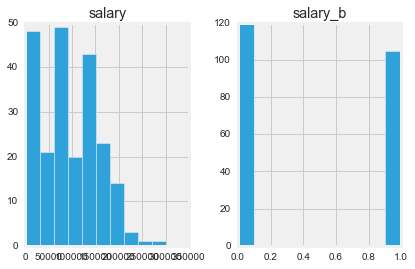

In [27]:
ndf.hist()

In [28]:
# create a new dataframe that contains both target and data
city = pd.concat([ndf['salary_b'], ndf['salary_type'],dummies.iloc[:,1:]], axis=1)

In [29]:
# # manually add the intercept
# city['intercept'] = 1.0
# city

In [30]:
# seperate year and month - see if it makes a difference
city_y = city[city['salary_type']=='year']
city_m = city[city['salary_type']=='month']

In [31]:
import statsmodels.api as sm

# set data and target, then fit model 
data = city[list(city.columns[2:])]
target = city["salary_b"]

x = data.as_matrix(columns=None)
y = target.as_matrix(columns=None)

logit_sm = sm.Logit(y, x)
# fit the model
result_sm = logit_sm.fit()
print result_sm.summary()

Optimization terminated successfully.
         Current function value: 0.624350
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  224
Model:                          Logit   Df Residuals:                      220
Method:                           MLE   Df Model:                            3
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                 0.09671
Time:                        10:12:01   Log-Likelihood:                -139.85
converged:                       True   LL-Null:                       -154.83
                                        LLR p-value:                 1.417e-06
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.7419      0.384      1.931      0.053        -0.011     1.495
x2            -0.1957      0.

In [32]:
# see what happens to the model if we only do yearly salary
data = city_y[list(city.columns[2:])]
target = city_y["salary_b"]

x = data.as_matrix(columns=None)
y = target.as_matrix(columns=None)

logit_sm = sm.Logit(y, x)
# fit the model
result_sm = logit_sm.fit()

print result_sm.summary()

Optimization terminated successfully.
         Current function value: 0.608714
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  175
Model:                          Logit   Df Residuals:                      171
Method:                           MLE   Df Model:                            3
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                 0.09554
Time:                        10:12:01   Log-Likelihood:                -106.52
converged:                       True   LL-Null:                       -117.78
                                        LLR p-value:                 5.123e-05
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.7419      0.384      1.931      0.053        -0.011     1.495
x2            -0.1733      0.

In [33]:
# get AIC and BIC
print result_sm.aic
print result_sm.bic

221.049925031
233.709068927


In [34]:
result_sm.conf_int()

array([[-0.01110481,  1.4949795 ],
       [-0.61045486,  0.26391141],
       [ 0.91378149,  2.79881449],
       [-0.16780176,  1.91873924]])

In [35]:
# get odds ratio 
import numpy as np
print city_y.columns[2:]
print np.exp(result_sm.params)

Index([u'Chicago', u'New York', u'San Francisco', u'Seattle'], dtype='object')
[ 2.1         0.84090909  6.4         2.4       ]


In [36]:
# set different parameters
params = result_sm.params
conf = pd.DataFrame(result_sm.conf_int())
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)

       2.5%      97.5%        OR
0  0.988957   4.459245  2.100000
1  0.543104   1.302013  0.840909
2  2.493735  16.425163  6.400000
3  0.845521   6.812364  2.400000


In [37]:
# Marginal Effect 
result_margeff = result_sm.get_margeff()
print result_margeff.summary() 

        Logit Marginal Effects       
Dep. Variable:                      y
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.1568      0.078      2.020      0.043         0.005     0.309
x2            -0.0366      0.047     -0.783      0.434        -0.128     0.055
x3             0.3922      0.087      4.531      0.000         0.223     0.562
x4             0.1850      0.109      1.697      0.090        -0.029     0.399


In [38]:
city.columns

Index([u'salary_b', u'salary_type', u'Chicago', u'New York', u'San Francisco',
       u'Seattle'],
      dtype='object')

In [39]:
city_y['salary_b_pred'] = result_sm.predict(x)

/Users/Lydia/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [40]:
city_y.salary_b_pred.value_counts()

0.456790    81
0.864865    37
0.677419    31
0.705882    17
0.500000     9
Name: salary_b_pred, dtype: int64

In [41]:
city.Chicago.value_counts()

0.0    193
1.0     31
Name: Chicago, dtype: int64

In [42]:
city['New York'].value_counts()

0.0    142
1.0     82
Name: New York, dtype: int64

The coefficient shows whether the salary is going to be high in certain cities compare to Austin. For example, Chicago, Seattle, San Francisco all have higher salary than the baseline Austin in the yearly salary model, but New York has lower salary than Austin. The coefficients tells us how that feature is compare to the baseline. However in order to get the odds, we need to take the exponent of the coefficient. We can also tell from the predicted probability that, Chicago's od of having a high salary is 67.7% , vs. New York is only 45.7% possible of being high compared to Austin. 

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Logistic Regression model with these features. Do they add any value? 


In [43]:
ndf

,city,company,salary,summary,title,salary_type,salary_v,salary_b
0,San Francisco,MarkMonitor,180000.0,"Data skills (SQL, Hive, Pig). Applying machine...",Data Scientist,year,high,1
1,San Francisco,Workbridge Associates,155000.0,3+ years of industry experience in a data scie...,Senior Data Scientist,year,high,1
2,San Francisco,Mines.io,100000.0,We are looking for a data scientist/developer ...,Full-Stack Data Scientist,year,high,1
3,San Francisco,Workbridge Associates,165000.0,In this position you will share programming an...,Data Scientist,year,high,1
4,San Francisco,Smith Hanley Associates,140000.0,"This person will recruit, build and lead a tea...",Data Scientist,year,high,1
5,San Francisco,HSF Consulting,300000.0,Teams included Data Services(including data en...,VP of Data Services,year,high,1
6,San Francisco,All-In Analytics,125000.0,Fraud Data Scientist. Seeking someone with ski...,Fraud Data Scientist,year,high,1
7,San Francisco,Brilent,130000.0,"Perform large-scale data analysis, find intere...",Senior Data Scientist,year,high,1
8,San Francisco,HSF Consulting,160000.0,More data- they simply have more data than the...,Senior Data Scientist,year,high,1
10,San Francisco,Jobspring Partners,162500.0,Given the high volume of data collected by the...,Python Developer (Machine Learning),year,high,1


In [44]:
# create dummy for titles that indicates higher level jobs. 
title_s = []
for x in ndf['title']:
    if 'Manager' in x: 
        title_s.append(1)
    elif 'Senior' in x: 
        title_s.append(1)
    elif 'VP' in x: 
        title_s.append(1)
    elif 'Director' in x: 
        title_s.append(1)
    else: 
        title_s.append(0)
ndf['title_s'] = title_s

# ndf['title_s'] = ndf['title'].map(lambda x: 1 if ('Manager' or 'Senior' or 'VP') in x else 0)

# the pre-scrapped dataset seems like there is a lot of duplicates of a few numbers, 
# It's probably becuase the last page is scrapped multiple times (Indeed only shows up to 100 pages of results).  

In [45]:
# add the new dummy column to the dataframe 
city['title_s'] = ndf['title_s']

In [46]:
# create a new dataframe and drop the predicted salary column
city_t = city
city_t = city_t.drop(['salary_b_pred'], axis =1)
city_t

ValueError: labels ['salary_b_pred'] not contained in axis

In [47]:
# build a new model based on it! 
data = city_t[list(city_t.columns[2:])]
target = city_t["salary_b"]

x = data.as_matrix(columns=None)
y = target.as_matrix(columns=None)

logit = sm.Logit(y, x)
# fit the model
result = logit.fit()

print result.summary()
print 'AIC: ' + str(result.aic) 
print 'BIC: ' + str(result.bic)

Optimization terminated successfully.
         Current function value: 0.591093
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  224
Model:                          Logit   Df Residuals:                      219
Method:                           MLE   Df Model:                            4
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.1448
Time:                        10:12:14   Log-Likelihood:                -132.40
converged:                       True   LL-Null:                       -154.83
                                        LLR p-value:                 4.283e-09
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.3075      0.412      0.747      0.455        -0.499     1.114
x2            -0.5210      0.

#### Rebuild this model with scikit-learn.
- You can either create the dummy features manually or use the `dmatrix` function from `patsy`
- Remember to scale the feature variables as well!


In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import confusion_matrix

In [49]:
data

,Chicago,New York,San Francisco,Seattle,title_s
0,0.0,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,1
2,0.0,0.0,1.0,0.0,0
3,0.0,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0
5,0.0,0.0,1.0,0.0,1
6,0.0,0.0,1.0,0.0,0
7,0.0,0.0,1.0,0.0,1
8,0.0,0.0,1.0,0.0,1
10,0.0,0.0,1.0,0.0,0


In [65]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  224
Model:                          Logit   Df Residuals:                      219
Method:                           MLE   Df Model:                            4
Date:                Fri, 08 Jul 2016   Pseudo R-squ.:                  0.1448
Time:                        10:15:10   Log-Likelihood:                -132.40
converged:                       True   LL-Null:                       -154.83
                                        LLR p-value:                 4.283e-09
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.3075      0.412      0.747      0.455        -0.499     1.114
x2            -0.5210      0.246     -2.116      0.034        -1.003    -0.039
x3             1.2290      0.428      2.871      0.004         0.390     2.068
x4            -1.1186      0.353     -3.171      0.002        -1.810    -0.427
x5             1.5189      0.423      3.593      0.000         0.690     2.348
==============================================================================
"""

In [66]:
predictions = result_sk.predict(x)
cm = confusion_matrix(y, predictions)
cm

ValueError: Can't handle mix of binary and continuous

In [63]:
import matplotlib.patheffects as path_effects

def plot_confusion_matrix(cm, title='Confusion matrix', labels=['Positive','Negative'], cmap=plt.cm.Blues):
    
    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
        
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.colorbar()
    plt.tight_layout()
    
    width, height = cm.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, foreground='black'),
                                                       path_effects.Normal()]) #The last line here adds a text outline

In [64]:
plot_confusion_matrix(cm, title='Confusion matrix', labels=['Low','High'], cmap=plt.cm.Blues)

NameError: name 'cm' is not defined

In [ ]:
# plt.figure(figsize=(10,6))
# ax = plt.subplot(111)

# for e, c in enumerate(city_t):
#     city_t[city_t[days[e]] == 1].plot(x='CRS_DEP_TIME', y='probability', kind='scatter', label = names[e], color = c, ax=ax)

# ax.legend(loc='upper left')
# ax.set_title('Probability of Delay\n Based on Day of Week and Time of Day')
# ax.set_xlabel('Scheduled departure time (2400 clock)')

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy, AUC, precision and recall of the model. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

print 'Accuracy_score: ' + str(accuracy_score(y, predictions))
print 'Precision_score: ' + str(precision_score(y, predictions))
print 'Recall_score: ' + str(recall_score(y, predictions))

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import train_test_split

roc = roc_curve(y, city_t.Prob)
roc

def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', ylabel = '% of True Positives'):
    
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title)
    plt.legend(loc='best')

In [ ]:
getROCcurve(roc)

#### Compare L1 and L2 regularization for this logistic regression model. What effect does this have on the coefficients learned?

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, cross_val_score

lr_l1 = LogisticRegression(C=1.5, penalty='l1', solver='liblinear')
lr_l1_model = lr_l1.fit(x, y)
lr_l1_ypred = lr_l1_model.predict(x)

In [ ]:
lr_l1_cm = confusion_matrix(y, lr_l1_ypred, labels=lr_l1.classes_)
lr_l1_cm = pd.DataFrame(lr_l1_cm, columns=lr_l1.classes_, index=lr_l1.classes_)
print lr_l1_cm
plot_confusion_matrix(lr_l1_cm, title='Confusion matrix', labels=['Low','High'], cmap=plt.cm.Blues)

In [ ]:
cross_val_score(lr_l1, x, y, cv=3).mean()

In [ ]:
lr2 = LogisticRegression(penalty='l2')
lr2_model = lr2.fit(x, y)
vice_y2_pred = lr2.predict(x)
cm2 = confusion_matrix(y, vice_y2_pred, labels=lr2.classes_)
cm2 = pd.DataFrame(cm2, columns=lr2.classes_, index=lr2.classes_)
print cm2
# plot_confusion_matrix(cm2, title='Confusion matrix', labels=['Low','High'], cmap=plt.cm.Blues)

In [ ]:
## YOUR CODE HERE
logreg = LogisticRegression(solver='liblinear')
C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = GridSearchCV(logreg, {'penalty': penalties, 'C': C_vals}, verbose=False, cv=15)
gs.fit(x, y)
gs.best_params_

#### Continue to incorporate other text features from the title or summary that you believe will predict the salary and examine their coefficients

#### Take ~100 scraped entries with salaries. Convert them to use with your model and predict the salary - which entries have the highest predicted salaries?

### BONUS 

#### Bonus: Use Count Vectorizer from scikit-learn to create features from the text summaries. 
- Examine using count or binary features in the model
- Re-evaluate the logistic regression model using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [ ]:
## YOUR CODE HERE

In [ ]:
## YOUR CODE HERE

#### Re-test L1 and L2 regularization. You can use LogisticRegressionCV to find the optimal reguarlization parameters. 
- Re-test what text features are most valuable.  
- How do L1 and L2 change the coefficients?

In [ ]:
## YOUR CODE HERE